<a href="https://colab.research.google.com/github/MatthewK84/Python-Code/blob/main/ENGG_408_Lab_Assignment_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 4: Support Vector Machines

## Overview
In this assignment, you will implement and analyze a Support Vector Machine (SVM).

We've attached a dataset, `MNIST.mat`, located in `/home/jovyan/work`, containing a sample of the famous MNIST benchmark. In this lab, you will develop predictive models for this data set and write a report on your findings. You will have less guidance in this lab, as you have more experience in the programming environment and we want you to have more ownership of your work. If you have questions, please reach out early and often.


### Roadmap
In this lab, you will answer five questions where we:

1. Train a SVM to perform binary classification with non-linear kernels.

2. Implement a predictive model.

3. Compare the performance of two voting schemes.

4. Discuss your strategy for hyperparameter tuning.

5. Generate multiclass confusion matricies for your model.

### Restriction
You are not allowed to import an SVM from, for instance, `scikit-learn`.
You may, however, use a library (such as `scipy.optimize.minimize` or `cvxopt.solvers.qp`) for the optimization process. The code to install the `cvxopt` library is included in the first code cell, if needed.

### Goals of This Lab
The goals of this lab are to:

1. Give you experience constructing and analyzing SVMs.

2. Continue to hone your communication skills through a brief report.

### Expectations
All lab submissions are individual and every item you submit should be a reflection of your own work. You should have ownership over the entirety of any lab you submit in this course. While your work is your own, we understand that it can be helpful in learning machine learning to collaborate with your peers, which can range from high-level discussion of a problem to debugging. Having others look at our code encourages us to write code with readability in mind. In practice, we will never work in a silo, and being able to discuss these topics with others well is a valuable skill. When you collaborate with another student, please cite them appropriately and be respectful of sharing too much. The Academic Honor Principle applies.

We respectfully ask that in the interest in furthering your own understanding of the material, that you refrain from using generative AI to code for you. Your work should be your own and you should feel comfortable justifying each design decision you make.

Please cite any outside sources you reference.

### Evaluation
You will be evaluated on the quality of your code and report. Your report must provide summaries of each method's performance and some additional details of your implementation. Compare the relative strengths and weaknesses of the methods based on both the experimental results and your understanding of the algorithms.

### What to Submit
Please submit the following:

1. A link to your notebook so the TAs can evaluate your code.

2. A brief write-up that answers the 5 questions posed in this lab and justifies your model. Ensure that any figures you create are accessible and easy to understand.

### Library Installation:
In this lab we will use the cvxopt library, whose documentation can be found here: https://cvxopt.org/userguide/index.html.

We are using version 1.3.2 of cvxopt. You need only run this command once a lab session, then you may comment out the command for future runs of the notebook.

In [1]:
!pip install cvxopt

In [9]:
import numpy as np
from scipy.io import loadmat
import cvxopt
import cvxopt.solvers
from cvxopt import matrix, solvers
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

### Accessing the Data
You can load the data with `scipy.io.loadmat`, which will return a Python dictionary containing the test and train data and labels.

In [3]:
##Import the data
mnist = loadmat('MNIST.mat')
test_samples = mnist['test_samples']
test_samples_labels = mnist['test_samples_labels'].flatten()
train_samples = mnist['train_samples']
train_samples_labels = mnist['train_samples_labels'].flatten()

## Question 1:
Develop code for training an SVM for binary classification with nonlinear kernels. You'll need to accomodate non-overlapping class distributions. One way to implement this is to maximize (7.32) subject to (7.33) and (7.34). It may be helpful to redefine these as matrix operations. Let ${1}\in\mathbb{R}^{N\times 1}$ be the vector whose entries are all 1's. Let $\mathbf{a}\in\mathbb{R}^{N\times 1}$ have entries $a_i$. Let $\mathbf{T}\in\mathbb{R}^{N\times N}$ be a diagonal matrix with $\mathbf{T}_{ii} = t_i$ on the diagonal. Then we can reformulate the objective to be

\begin{equation*}
\begin{aligned}
& \text{maximize}
& & \tilde{L}(\mathbf{a}) = {1}^{\mathrm{T}}\mathbf{a} - \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} \\
& \text{subject to}
& & {1}^{\mathrm{T}} \mathbf{a} \preceq C \\
& & & {1}^{\mathrm{T}} \mathbf{a} \succeq 0 \\
& & & \mathbf{a}^{\mathrm{T}} \mathbf{t} = 0
\end{aligned}
\end{equation*}

The "$\preceq$" symbol here means element-wise comparison. This formulation is very close to what `cvxopt` expects.

Hint (`cvxopt` expects the following form):

\begin{equation*}
\begin{aligned}
& \text{minimize}
& & \tilde{L}(\mathbf{a}) = \frac{1}{2} \mathbf{a}^{\mathrm{T}} \mathbf{T}\mathbf{K} \mathbf{T}\mathbf{a} - {1}^{\mathrm{T}}\mathbf{a} \\
& \text{subject to}
& & G \mathbf{a} \preceq h \\
& & & {\mathbf{t}}^{\mathrm{T}}\mathbf{a} = 0
\end{aligned}
\end{equation*}

where $G$ is an $N\times N$ identity matrix ontop of $-1$ times an $N\times N$ identity matrix and $h \in\mathbb{R}^{2N}$ where the first $N$ entries are $C$ and the second $N$ enties are $0$.

In [14]:
def rbf_kernel(X, y, gamma=0.05):
    if y.ndim == 1:
        y = y.reshape(1, -1)
    sq_dists = np.sum((X - y) ** 2, axis=1)
    return np.exp(-gamma * sq_dists)

def train_svm(X, y, C, kernel):
    n_samples, n_features = X.shape
    K = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j])[0]  # Extract the scalar value from the array

    T = np.diag(y)
    P = matrix(np.dot(T, np.dot(K, T)))
    q = matrix(-np.ones(n_samples))

    G = matrix(np.vstack((np.eye(n_samples), -np.eye(n_samples))))
    h = matrix(np.hstack((np.ones(n_samples) * C, np.zeros(n_samples))))

    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)

    solvers.options['show_progress'] = True
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])

    sv = alphas > 1e-5
    ind = np.arange(len(alphas))[sv]
    alpha_sv = alphas[sv]
    sv_y = y[sv]
    sv_x = X[sv]

    b = np.mean([sv_y[i] - np.sum(alpha_sv * sv_y * K[ind[i], sv]) for i in range(len(alpha_sv))])

    return {
        'alphas': alpha_sv,
        'b': b,
        'sv_x': sv_x,
        'sv_y': sv_y,
        'ind': ind
    }

def predict(X, sv, sv_y, alphas, b, kernel):
    y_predict = np.zeros(len(X))
    for i in range(len(X)):
        k_values = np.array([kernel(X[i], s)[0] for s in sv])  # Extract the scalar value from the array
        y_predict[i] = np.sum(alphas * sv_y * k_values) + b
    return np.sign(y_predict)

# Define train_samples, train_labels, test_samples, test_labels
train_y = np.where(train_samples_labels == 0, 1, -1)
test_y = np.where(test_samples_labels == 0, 1, -1)

model = train_svm(train_samples, train_y, C=1.0, kernel=lambda x, y: rbf_kernel(x, y, gamma=0.05))
predictions = predict(test_samples, model['sv_x'], model['sv_y'], model['alphas'], model['b'], lambda x, y: rbf_kernel(x, y, gamma=0.05))

accuracy = np.mean(predictions == test_y)
print(f"Accuracy: {accuracy * 100:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -5.1336e+02 -8.3974e+03  4e+04  3e+00  2e-14
 1: -3.2328e+02 -4.6759e+03  7e+03  2e-01  2e-14
 2: -2.4786e+02 -1.1123e+03  1e+03  3e-02  2e-14
 3: -2.9954e+02 -7.5254e+02  5e+02  1e-02  2e-14
 4: -3.3476e+02 -6.0905e+02  3e+02  6e-03  2e-14
 5: -3.5686e+02 -5.3568e+02  2e+02  3e-03  2e-14
 6: -3.7107e+02 -4.9341e+02  1e+02  2e-03  1e-14
 7: -3.8632e+02 -4.5081e+02  7e+01  9e-04  2e-14
 8: -3.9242e+02 -4.3652e+02  5e+01  5e-04  2e-14
 9: -3.9790e+02 -4.2451e+02  3e+01  2e-04  2e-14
10: -4.0391e+02 -4.1357e+02  1e+01  7e-05  2e-14
11: -4.0653e+02 -4.0935e+02  3e+00  2e-05  2e-14
12: -4.0756e+02 -4.0780e+02  2e-01  1e-14  2e-14
13: -4.0767e+02 -4.0768e+02  6e-03  7e-15  2e-14
14: -4.0768e+02 -4.0768e+02  1e-04  1e-15  2e-14
Optimal solution found.
Accuracy: 98.30%


## Question 2:
Develop code to predict the $\{-1,+1\}$ class for new data. To use the predictive model (7.13) you need to determine $b$, which can be done with (7.37).

In [15]:
def rbf_kernel(X, Y, gamma=0.05):
    if Y.ndim == 1:
        Y = Y.reshape(1, -1)
    sq_dists = np.sum((X[:, np.newaxis] - Y) ** 2, axis=2)
    return np.exp(-gamma * sq_dists)

def train_svm(X, y, C, kernel, gamma=0.05):
    n_samples = X.shape[0]
    # Use a Smaller Subset of Data to Prevent crashing
    sample_idx = np.random.choice(n_samples, size=min(1000, n_samples), replace=False)
    X_sub = X[sample_idx]
    y_sub = y[sample_idx]
    # Compute Kernel Matrix
    K = kernel(X_sub, X_sub, gamma)
    P = matrix(np.outer(y_sub, y_sub) * K)
    q = matrix(-np.ones(len(X_sub)))
    G = matrix(np.vstack((np.eye(len(X_sub)) * -1, np.eye(len(X_sub)))))
    h = matrix(np.hstack((np.zeros(len(X_sub)), np.ones(len(X_sub)) * C)))
    A = matrix(y_sub, (1, len(X_sub)), 'd')
    b = matrix(0.0)
    solvers.options['show_progress'] = True
    solution = solvers.qp(P, q, G, h, A, b)
    alphas = np.ravel(solution['x'])
    # Support Vectors Have Non-Zero Lagrange Multipliers
    sv = alphas > 1e-5
    ind = np.arange(len(alphas))[sv]
    alpha_sv = alphas[sv]
    sv_y = y_sub[sv]
    sv_x = X_sub[sv]
    # Calculate Intercept b Using Equation (7.37)
    b = np.mean([sv_y[i] - np.sum(alpha_sv * sv_y * K[ind[i], sv]) for i in range(len(alpha_sv))])
    return {'alphas': alpha_sv, 'b': b, 'sv_x': sv_x, 'sv_y': sv_y}

def predict(X, model, kernel, gamma=0.05):
    alpha_sv, sv_y, sv_x, b = model['alphas'], model['sv_y'], model['sv_x'], model['b']
    K_pred = kernel(X, sv_x, gamma)
    y_predict = np.dot(K_pred, alpha_sv * sv_y) + b
    return np.sign(y_predict)

# Preprocess Labels for Binary Classification (class 9 vs. all others)
train_labels_binary = np.where(train_samples_labels == 9, 1, -1)
test_labels_binary = np.where(test_samples_labels == 9, 1, -1)

# Train SVM model
model = train_svm(train_samples, train_labels_binary, C=5.0, kernel=rbf_kernel, gamma=0.05)

# Make Predictions
predictions = predict(test_samples, model, rbf_kernel, gamma=0.05)

# Evaluate Accuracy
accuracy = np.mean(predictions == test_labels_binary)
print(f"Accuracy: {accuracy * 100:.2f}%")

     pcost       dcost       gap    pres   dres
 0: -6.2291e+02 -1.3893e+04  3e+04  5e-01  3e-14
 1: -4.6943e+02 -3.1781e+03  3e+03  1e-14  3e-14
 2: -6.3207e+02 -1.8207e+03  1e+03  1e-14  3e-14
 3: -7.1556e+02 -1.5590e+03  8e+02  4e-15  3e-14
 4: -7.9787e+02 -1.2670e+03  5e+02  1e-14  3e-14
 5: -8.4400e+02 -1.1302e+03  3e+02  1e-15  3e-14
 6: -8.7336e+02 -1.0489e+03  2e+02  2e-14  3e-14
 7: -9.0098e+02 -9.8213e+02  8e+01  3e-14  3e-14
 8: -9.1778e+02 -9.4548e+02  3e+01  2e-14  4e-14
 9: -9.2625e+02 -9.3174e+02  5e+00  1e-14  4e-14
10: -9.2835e+02 -9.2876e+02  4e-01  3e-14  4e-14
11: -9.2853e+02 -9.2856e+02  3e-02  2e-14  4e-14
12: -9.2854e+02 -9.2854e+02  5e-04  5e-15  4e-14
Optimal solution found.
Accuracy: 96.40%


## Question 3:
Using your implementation, compare multiclass classification performance of two different voting schemes:

* one versus rest
* one versus one

In [8]:
class SVM:
    def __init__(self, kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.a = None
        self.sv_x = None
        self.sv_y = None
        self.b = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i,j] = self.kernel(X[i], X[j])

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y, (1, n_samples), 'd')
        b = matrix(0.0)

        solution = solvers.qp(P, q, G, h, A, b)
        self.a = np.ravel(solution['x'])

        sv = self.a > 1e-5
        ind = np.arange(len(self.a))[sv]
        self.a = self.a[sv]
        self.sv_x = X[sv]
        self.sv_y = y[sv]

        self.b = 0
        for i in range(len(self.a)):
            self.b += self.sv_y[i]
            self.b -= np.sum(self.a * self.sv_y * K[ind[i], sv])
        self.b /= len(self.a)

    def predict(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv_x in zip(self.a, self.sv_y, self.sv_x):
                s += a * sv_y * self.kernel(X[i], sv_x)
            y_predict[i] = s
        return np.sign(y_predict + self.b)

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def ovr_training(train_samples, train_samples_labels, kernel=linear_kernel, C=1.0):
    unique_classes = np.unique(train_samples_labels)
    binary_classifiers = []
    for i in unique_classes:
        class_ovr = np.where(train_samples_labels == i, 1, -1)
        classifier = SVM(kernel=kernel, C=C)
        classifier.fit(train_samples, class_ovr)
        binary_classifiers.append(classifier)
    return binary_classifiers

def ovo_training(train_samples, train_samples_labels, kernel=linear_kernel, C=1.0):
    unique_classes = np.unique(train_samples_labels)
    binary_classifiers = []
    labels = []
    for i in range(len(unique_classes)):
        for j in range(i + 1, len(unique_classes)):
            pair_ovo = np.where((train_samples_labels == unique_classes[i]) | (train_samples_labels == unique_classes[j]))[0]
            pair_ovo_x = train_samples[pair_ovo]
            pair_ovo_y = train_samples_labels[pair_ovo]
            pair_ovo_y = np.where(pair_ovo_y == unique_classes[i], 1, -1)
            classifier = SVM(kernel=kernel, C=C)
            classifier.fit(pair_ovo_x, pair_ovo_y)
            binary_classifiers.append(classifier)
            labels.append((unique_classes[i], unique_classes[j]))
    return binary_classifiers, labels

def ovr_test(classifiers, test_samples):
    num_classes = len(classifiers)
    num_samples = test_samples.shape[0]
    scores = np.zeros((num_samples, num_classes))
    for i, classifier in enumerate(classifiers):
        scores[:, i] = classifier.predict(test_samples)
    y_pred = np.argmax(scores, axis=1)
    return y_pred

def ovo_test(classifiers, labels, test_samples):
    num_classes = len(set([label for pair in labels for label in pair]))
    num_samples = test_samples.shape[0]
    votes = np.zeros((num_samples, num_classes))
    for classifier, (i1, i2) in zip(classifiers, labels):
        predictions = classifier.predict(test_samples)
        votes[:, i1] += (predictions == 1)
        votes[:, i2] += (predictions == -1)
    y_pred = np.argmax(votes, axis=1)
    return y_pred

# Train binary classifiers using the one-versus-rest approach
classifiers_ovr = ovr_training(train_samples, train_samples_labels)

# Train binary classifiers using the one-versus-one approach
classifiers_ovo, labels = ovo_training(train_samples, train_samples_labels)

# Predict class labels using the one-versus-rest approach
y_pred_ovr = ovr_test(classifiers_ovr, test_samples)

# Predict class labels using the one-versus-one approach
y_pred_ovo = ovo_test(classifiers_ovo, labels, test_samples)

# Evaluate performance
accuracy_ovr = np.mean(y_pred_ovr == test_samples_labels)
accuracy_ovo = np.mean(y_pred_ovo == test_samples_labels)

print(f"Accuracy (One-vs-Rest): {accuracy_ovr: .2f}")
print(f"Accuracy (One-vs-One): {accuracy_ovo: .2f}")

     pcost       dcost       gap    pres   dres
 0: -4.2755e+02 -7.7912e+03  4e+04  3e+00  1e-14
 1: -2.6542e+02 -4.2711e+03  7e+03  3e-01  9e-15
 2: -1.5017e+02 -1.2639e+03  2e+03  7e-02  8e-15
 3: -1.2512e+02 -7.1612e+02  9e+02  3e-02  7e-15
 4: -1.2271e+02 -3.4252e+02  3e+02  1e-02  8e-15
 5: -1.2809e+02 -2.5197e+02  1e+02  4e-03  8e-15
 6: -1.3594e+02 -2.1260e+02  9e+01  2e-03  8e-15
 7: -1.4147e+02 -1.7943e+02  4e+01  6e-05  9e-15
 8: -1.4962e+02 -1.6575e+02  2e+01  9e-06  9e-15
 9: -1.5390e+02 -1.5953e+02  6e+00  7e-07  1e-14
10: -1.5579e+02 -1.5719e+02  1e+00  3e-14  1e-14
11: -1.5642e+02 -1.5651e+02  9e-02  2e-14  1e-14
12: -1.5646e+02 -1.5647e+02  4e-03  8e-15  1e-14
13: -1.5646e+02 -1.5646e+02  6e-05  4e-14  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0051e+02 -9.1433e+03  5e+04  3e+00  9e-15
 1: -2.4919e+02 -5.2145e+03  9e+03  3e-01  8e-15
 2: -1.6048e+02 -1.3673e+03  2e+03  6e-02  6e-15
 3: -1.4164e+02 -7.2653e+02  8e+02  2e-02  5e-1

## Question 4:
The parameter $C>0$ controls the tradeoff between the size of the margin and the slack variable penalty. It is analogous to the inverse of a regularization coefficient. Include in your report a brief discussion of how you found an appropriate value.

In [ ]:
# Hint: Try using np.logspace for hyperparameter tuning

## Question 5:
In addition to calculating percent accuracy, generate multiclass [confusion matrices](https://en.wikipedia.org/wiki/confusion_matrix) as part of your analysis.

     pcost       dcost       gap    pres   dres
 0: -4.2755e+02 -7.7912e+03  4e+04  3e+00  1e-14
 1: -2.6542e+02 -4.2711e+03  7e+03  3e-01  9e-15
 2: -1.5017e+02 -1.2639e+03  2e+03  7e-02  8e-15
 3: -1.2512e+02 -7.1612e+02  9e+02  3e-02  7e-15
 4: -1.2271e+02 -3.4252e+02  3e+02  1e-02  8e-15
 5: -1.2809e+02 -2.5197e+02  1e+02  4e-03  8e-15
 6: -1.3594e+02 -2.1260e+02  9e+01  2e-03  8e-15
 7: -1.4147e+02 -1.7943e+02  4e+01  6e-05  9e-15
 8: -1.4962e+02 -1.6575e+02  2e+01  9e-06  9e-15
 9: -1.5390e+02 -1.5953e+02  6e+00  7e-07  1e-14
10: -1.5579e+02 -1.5719e+02  1e+00  3e-14  1e-14
11: -1.5642e+02 -1.5651e+02  9e-02  2e-14  1e-14
12: -1.5646e+02 -1.5647e+02  4e-03  8e-15  1e-14
13: -1.5646e+02 -1.5646e+02  6e-05  4e-14  1e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -4.0051e+02 -9.1433e+03  5e+04  3e+00  9e-15
 1: -2.4919e+02 -5.2145e+03  9e+03  3e-01  8e-15
 2: -1.6048e+02 -1.3673e+03  2e+03  6e-02  6e-15
 3: -1.4164e+02 -7.2653e+02  8e+02  2e-02  5e-1

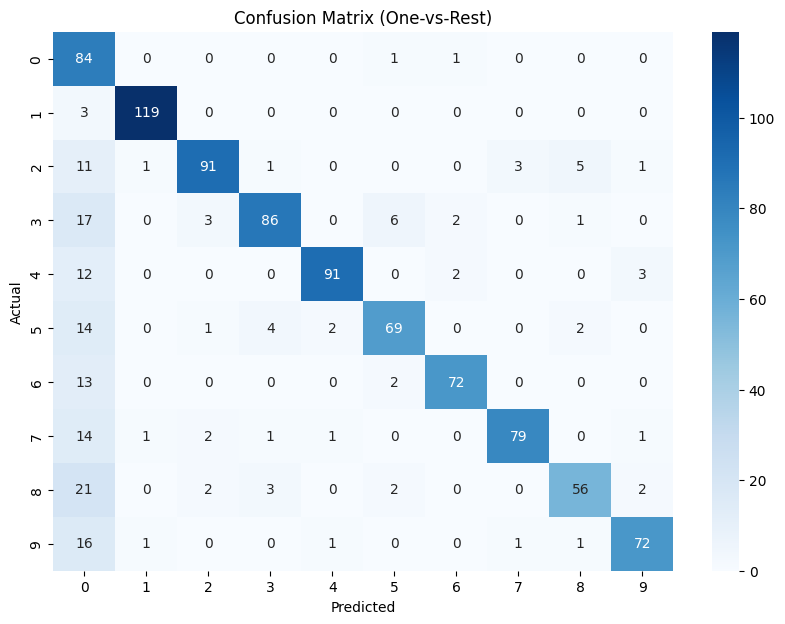

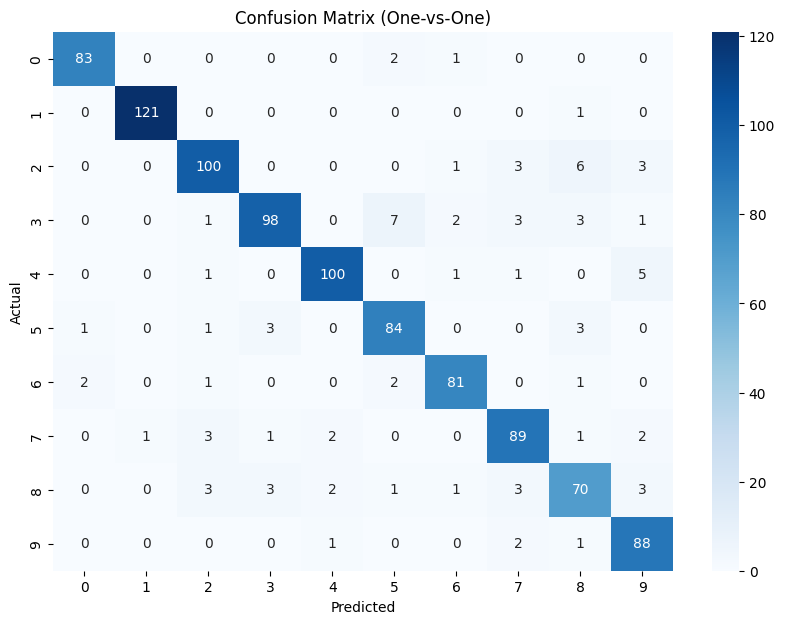

In [10]:
# SVM implementation using cvxopt
class SVM:
    def __init__(self, kernel, C=1.0):
        self.kernel = kernel
        self.C = C
        self.a = None
        self.sv_x = None
        self.sv_y = None
        self.b = 0

    def fit(self, X, y):
        n_samples, n_features = X.shape

        K = np.zeros((n_samples, n_samples))
        for i in range(n_samples):
            for j in range(n_samples):
                K[i, j] = self.kernel(X[i], X[j])

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones(n_samples))
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * self.C)))
        A = matrix(y, (1, n_samples), 'd')
        b = matrix(0.0)

        solution = solvers.qp(P, q, G, h, A, b)
        self.a = np.ravel(solution['x'])

        sv = self.a > 1e-5
        ind = np.arange(len(self.a))[sv]
        self.a = self.a[sv]
        self.sv_x = X[sv]
        self.sv_y = y[sv]

        self.b = 0
        for i in range(len(self.a)):
            self.b += self.sv_y[i]
            self.b -= np.sum(self.a * self.sv_y * K[ind[i], sv])
        self.b /= len(self.a)

    def predict(self, X):
        y_predict = np.zeros(len(X))
        for i in range(len(X)):
            s = 0
            for a, sv_y, sv_x in zip(self.a, self.sv_y, self.sv_x):
                s += a * sv_y * self.kernel(X[i], sv_x)
            y_predict[i] = s
        return np.sign(y_predict + self.b)

def linear_kernel(x1, x2):
    return np.dot(x1, x2)

def ovr_training(train_samples, train_samples_labels, kernel=linear_kernel, C=1.0):
    unique_classes = np.unique(train_samples_labels)
    binary_classifiers = []
    for i in unique_classes:
        class_ovr = np.where(train_samples_labels == i, 1, -1)
        classifier = SVM(kernel=kernel, C=C)
        classifier.fit(train_samples, class_ovr)
        binary_classifiers.append(classifier)
    return binary_classifiers

def ovo_training(train_samples, train_samples_labels, kernel=linear_kernel, C=1.0):
    unique_classes = np.unique(train_samples_labels)
    binary_classifiers = []
    labels = []
    for i in range(len(unique_classes)):
        for j in range(i + 1, len(unique_classes)):
            pair_ovo = np.where((train_samples_labels == unique_classes[i]) | (train_samples_labels == unique_classes[j]))[0]
            pair_ovo_x = train_samples[pair_ovo]
            pair_ovo_y = train_samples_labels[pair_ovo]
            pair_ovo_y = np.where(pair_ovo_y == unique_classes[i], 1, -1)
            classifier = SVM(kernel=kernel, C=C)
            classifier.fit(pair_ovo_x, pair_ovo_y)
            binary_classifiers.append(classifier)
            labels.append((unique_classes[i], unique_classes[j]))
    return binary_classifiers, labels

def ovr_test(classifiers, test_samples):
    num_classes = len(classifiers)
    num_samples = test_samples.shape[0]
    scores = np.zeros((num_samples, num_classes))
    for i, classifier in enumerate(classifiers):
        scores[:, i] = classifier.predict(test_samples)
    y_pred = np.argmax(scores, axis=1)
    return y_pred

def ovo_test(classifiers, labels, test_samples):
    num_classes = len(set([label for pair in labels for label in pair]))
    num_samples = test_samples.shape[0]
    votes = np.zeros((num_samples, num_classes))
    for classifier, (i1, i2) in zip(classifiers, labels):
        predictions = classifier.predict(test_samples)
        votes[:, i1] += (predictions == 1)
        votes[:, i2] += (predictions == -1)
    y_pred = np.argmax(votes, axis=1)
    return y_pred

# Confusion matrix creation
def confusion_matrix(y_true, y_pred):
    labels = np.unique(y_true)
    cm = np.zeros((len(labels), len(labels)), dtype=int)
    label_to_index = {label: index for index, label in enumerate(labels)}
    for i in range(len(y_true)):
        true_index = label_to_index[y_true[i]]
        pred_index = label_to_index[y_pred[i]]
        cm[true_index, pred_index] += 1
    return cm

# Confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Example usage
# Assume train_samples, train_samples_labels, test_samples, test_samples_labels are defined

# Train binary classifiers using the one-versus-rest approach
classifiers_ovr = ovr_training(train_samples, train_samples_labels)

# Train binary classifiers using the one-versus-one approach
classifiers_ovo, labels = ovo_training(train_samples, train_samples_labels)

# Predict class labels using the one-versus-rest approach
y_pred_ovr = ovr_test(classifiers_ovr, test_samples)

# Predict class labels using the one-versus-one approach
y_pred_ovo = ovo_test(classifiers_ovo, labels, test_samples)

# Evaluate performance
accuracy_ovr = np.mean(y_pred_ovr == test_samples_labels)
accuracy_ovo = np.mean(y_pred_ovo == test_samples_labels)

print(f"Accuracy (One-vs-Rest): {accuracy_ovr: .2f}")
print(f"Accuracy (One-vs-One): {accuracy_ovo: .2f}")

# Plot confusion matrices
plot_confusion_matrix(test_samples_labels, y_pred_ovr, "Confusion Matrix (One-vs-Rest)")
plot_confusion_matrix(test_samples_labels, y_pred_ovo, "Confusion Matrix (One-vs-One)")

### What to Submit
Please submit the following:

1. A link to your notebook so the TAs can evaluate your code.

2. A brief write-up that answers the 5 questions posed in this lab and justifies your model. Ensure that any figures you create are accessible and easy to understand.